In [76]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [13]:
fe = pd.read_csv('feature_engineering_sample.csv')
order_new = pd.read_csv('order_new.csv')
order_product_new = pd.read_csv('order_product_new.csv')

In [14]:
fe

,Unnamed: 0,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,...,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,0,1,196,10,176.0,17.60,59,18,0.759259,10,...,10.0,1.400000,114,0.653846,4.384615,0.771930,5.90,1.00,0.0,1.000000
1,1,1,10258,10,176.0,17.60,59,18,0.759259,9,...,10.0,3.333333,9,1.000000,9.000000,0.888889,5.90,0.90,0.0,1.000000
2,2,1,10326,10,176.0,17.60,59,18,0.759259,1,...,5.0,5.000000,14,0.444444,1.555556,0.357143,5.90,0.10,5.0,0.166667
3,3,1,12427,10,176.0,17.60,59,18,0.759259,10,...,10.0,3.300000,30,0.571429,4.285714,0.766667,5.90,1.00,0.0,1.000000
4,4,1,13032,10,176.0,17.60,59,18,0.759259,3,...,10.0,6.333333,5,0.333333,1.666667,0.400000,5.90,0.30,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39481,39481,633,29382,4,77.0,19.25,15,11,0.333333,1,...,2.0,6.000000,8,0.400000,1.600000,0.375000,3.75,0.25,2.0,0.333333
39482,39482,633,31759,4,77.0,19.25,15,11,0.333333,2,...,2.0,2.000000,19,1.000000,3.800000,0.736842,3.75,0.50,2.0,0.500000
39483,39483,633,32455,4,77.0,19.25,15,11,0.333333,1,...,3.0,2.000000,13,0.285714,1.857143,0.461538,3.75,0.25,1.0,0.500000
39484,39484,633,40603,4,77.0,19.25,15,11,0.333333,1,...,2.0,4.000000,2,NaN,1.000000,0.000000,3.75,0.25,2.0,0.333333


In [15]:
order_new 

,Unnamed: 0,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,0,2539329,1,1,2,8,NaN,Prior
1,1,2398795,1,2,3,7,15.0,Prior
2,2,473747,1,3,3,12,21.0,Prior
3,3,2254736,1,4,4,7,29.0,Prior
4,4,431534,1,5,4,15,28.0,Prior
...,...,...,...,...,...,...,...,...
3421078,3421078,2266710,206209,10,5,18,29.0,Prior
3421079,3421079,1854736,206209,11,4,10,30.0,Prior
3421080,3421080,626363,206209,12,1,12,18.0,Prior
3421081,3421081,2977660,206209,13,1,12,7.0,Prior


In [16]:
order_product_new

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,0,2539329,196,1,0
1,1,2539329,14084,2,0
2,2,2539329,12427,3,0
3,3,2539329,26088,4,0
4,4,2539329,26405,5,0
...,...,...,...,...,...
33819101,33819101,272231,40603,4,0
33819102,33819102,272231,15655,5,0
33819103,33819103,272231,42606,6,0
33819104,33819104,272231,37966,7,0


In [17]:
fe.drop('Unnamed: 0', axis = 1, inplace = True)
order_new.drop('Unnamed: 0', axis = 1, inplace = True)
order_product_new.drop('Unnamed: 0', axis = 1, inplace = True)

In [18]:
data = pd.DataFrame({
                     'user_id': order_new['user_id'],
                     'eval_set': order_new['eval_set']
                    })
data = data[data['eval_set'] != 'Prior']

In [19]:
df = pd.merge(fe, data, on = 'user_id', how = 'left')
df.head()

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
0,1,196,10,176.0,17.6,59,18,0.759259,10,1.0,...,1.400000,114,0.653846,4.384615,0.771930,5.9,1.0,0.0,1.000000,Train
1,1,10258,10,176.0,17.6,59,18,0.759259,9,2.0,...,3.333333,9,1.000000,9.000000,0.888889,5.9,0.9,0.0,1.000000,Train
2,1,10326,10,176.0,17.6,59,18,0.759259,1,5.0,...,5.000000,14,0.444444,1.555556,0.357143,5.9,0.1,5.0,0.166667,Train
3,1,12427,10,176.0,17.6,59,18,0.759259,10,1.0,...,3.300000,30,0.571429,4.285714,0.766667,5.9,1.0,0.0,1.000000,Train
4,1,13032,10,176.0,17.6,59,18,0.759259,3,2.0,...,6.333333,5,0.333333,1.666667,0.400000,5.9,0.3,0.0,0.333333,Train


In [20]:
# split into train and test
df_train = df[df['eval_set'] == 'Train']
df_test = df[df['eval_set'] == 'Test']

In [21]:
eval_train = order_new[order_new['eval_set'] == 'Train']
eval_train_new = pd.merge(eval_train, order_product_new, on = 'order_id', how = 'left')

eval_train_new

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set,product_id,add_to_cart_order,reordered
0,1187899,1,11,4,8,14.0,Train,196,1,1
1,1187899,1,11,4,8,14.0,Train,25133,2,1
2,1187899,1,11,4,8,14.0,Train,38928,3,1
3,1187899,1,11,4,8,14.0,Train,26405,4,1
4,1187899,1,11,4,8,14.0,Train,39657,5,1
...,...,...,...,...,...,...,...,...,...,...
1384612,272231,206209,14,6,14,30.0,Train,40603,4,0
1384613,272231,206209,14,6,14,30.0,Train,15655,5,0
1384614,272231,206209,14,6,14,30.0,Train,42606,6,0
1384615,272231,206209,14,6,14,30.0,Train,37966,7,0


In [23]:
order_new_train = pd.DataFrame({
                               'user_id': eval_train_new['user_id'],
                               'product_id': eval_train_new['product_id'],
                               'reordered': eval_train_new['reordered']
                               })

In [24]:
train = pd.merge(df_train, order_new_train, on = ['user_id', 'product_id'], how = 'left')
train

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set,reordered
0,1,196,10,176.0,17.6,59,18,0.759259,10,1.0,...,114,0.653846,4.384615,0.771930,5.9,1.0,0.0,1.000000,Train,1.0
1,1,10258,10,176.0,17.6,59,18,0.759259,9,2.0,...,9,1.000000,9.000000,0.888889,5.9,0.9,0.0,1.000000,Train,1.0
2,1,10326,10,176.0,17.6,59,18,0.759259,1,5.0,...,14,0.444444,1.555556,0.357143,5.9,0.1,5.0,0.166667,Train,NaN
3,1,12427,10,176.0,17.6,59,18,0.759259,10,1.0,...,30,0.571429,4.285714,0.766667,5.9,1.0,0.0,1.000000,Train,NaN
4,1,13032,10,176.0,17.6,59,18,0.759259,3,2.0,...,5,0.333333,1.666667,0.400000,5.9,0.3,0.0,0.333333,Train,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24768,632,38928,5,50.0,10.0,21,16,0.250000,1,2.0,...,75,0.555556,8.333333,0.880000,4.2,0.2,3.0,0.250000,Train,1.0
24769,632,39275,5,50.0,10.0,21,16,0.250000,2,4.0,...,314,0.607477,2.934579,0.659236,4.2,0.4,0.0,1.000000,Train,NaN
24770,632,42282,5,50.0,10.0,21,16,0.250000,1,2.0,...,5,0.250000,1.250000,0.200000,4.2,0.2,3.0,0.250000,Train,NaN
24771,632,43352,5,50.0,10.0,21,16,0.250000,1,4.0,...,121,0.474576,2.050847,0.512397,4.2,0.2,1.0,0.500000,Train,NaN


In [43]:
train.fillna(0)
df_test.fillna(0)

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
120,3,248,12,133.0,11.083333,88,33,0.705128,1,2.0,...,3.000000,21,0.125000,1.312500,0.238095,7.333333,0.083333,10.0,0.090909,Test
121,3,1005,12,133.0,11.083333,88,33,0.705128,1,10.0,...,5.000000,7,0.200000,1.400000,0.285714,7.333333,0.083333,2.0,0.333333,Test
122,3,1819,12,133.0,11.083333,88,33,0.705128,3,4.0,...,2.666667,13,0.400000,2.600000,0.615385,7.333333,0.250000,5.0,0.333333,Test
123,3,7503,12,133.0,11.083333,88,33,0.705128,1,3.0,...,6.000000,18,0.307692,1.384615,0.277778,7.333333,0.083333,9.0,0.100000,Test
124,3,8021,12,133.0,11.083333,88,33,0.705128,1,2.0,...,5.000000,79,0.447368,2.078947,0.518987,7.333333,0.083333,10.0,0.090909,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39481,633,29382,4,77.0,19.250000,15,11,0.333333,1,2.0,...,6.000000,8,0.400000,1.600000,0.375000,3.750000,0.250000,2.0,0.333333,Test
39482,633,31759,4,77.0,19.250000,15,11,0.333333,2,1.0,...,2.000000,19,1.000000,3.800000,0.736842,3.750000,0.500000,2.0,0.500000,Test
39483,633,32455,4,77.0,19.250000,15,11,0.333333,1,3.0,...,2.000000,13,0.285714,1.857143,0.461538,3.750000,0.250000,1.0,0.500000,Test
39484,633,40603,4,77.0,19.250000,15,11,0.333333,1,2.0,...,4.000000,2,0.000000,1.000000,0.000000,3.750000,0.250000,2.0,0.333333,Test


Xgboost Model & Parameter tuning

In [44]:
train_sam = train.head(10000)

In [73]:
X_train = train_sam.drop(['reordered','eval_set'], axis = 1)
y_train = train_sam['reordered']
X_test = df_test.drop(['eval_set'],axis=1)

In [66]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/Rebecca/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [69]:
X_train.fillna(0, inplace=True)
y_train.fillna(0,inplace=True)

/Users/Rebecca/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [46]:
def kfold_index(x_train, k):
    if k < 1:
        print('K cannot smaller than 1')
        return
    else:
        l = x_train.shape[0] 
        tail = l % k
        q = l // k
        index = [0]
        output_index = []
        # first n_examples % k sub_example have n_examples // k + 1 elements
        for i in range(1,tail):
            index.append((i*q)+1)
        for j in range(tail,k+1):
            index.append(j*q+tail)          
        for m in range(len(index)-1):
            output_index.append([index[m],index[m+1]])
        if [0, 0] in output_index:
             output_index.remove([0, 0])    
        return output_index

# the evaluation method here is auc,
# the return include mean of auc for all k eval_sets and the mean of best boosting round 

def cv_xgboost(x_train, y_train, param, num_boosting_round, early_stoping_rounds, kfold):
    
    import xgboost as xgb
    from sklearn import metrics
    # get kfold index
    index = kfold_index(x_train, kfold)

    #train each sub-combination
    auc = []
    br = []
    for i in range(kfold):
        #print(index)
        cv_xtest = x_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = y_train.iloc[index[i][0]:index[i][1],]
        
        # drop the test sub-set 
        cv_xtrain = x_train.drop(x_train.index[index[i][0]:index[i][1]])
        cv_ytrain = y_train.drop(y_train.index[index[i][0]:index[i][1]])
        
        # make the dmatrix for xgboost
        
        d_cvtrain = xgb.DMatrix(data = cv_xtrain, label = cv_ytrain)
        d_cvtest = xgb.DMatrix(data = cv_xtest, label = cv_ytest)
        
        # use xgb.train to train the model
        xg_l = xgb.train(params = param, 
                         dtrain = d_cvtrain, 
                         num_boost_round = num_boosting_round, 
                         early_stopping_rounds = early_stoping_rounds, 
                         evals = [(d_cvtest, 'test_evalset')],
                         verbose_eval = False)
        
        # calculate the auc as the evaluation metric
        fpr, tpr, threshold = roc_curve(cv_ytest, xg_l.predict(d_cvtest))
        aa = metrics.auc(fpr, tpr)
        auc.append(aa)  
        
        bb = xg_l.best_iteration
        br.append(bb)
        
    return np.mean(auc), np.mean(br)

In [47]:
param_grid = {
              'eta': [0.03, 0.1, 0.15],
              'subsample': [0.5,0.75,0.9],
              'max_depth': range(3, 5, 10),
              'colsample_bytree': [0.5, 0.75,0.95],
             }

In [48]:
s = sorted(param_grid)
combination = it.product(*(param_grid[Name] for Name in s))
print(s)

['colsample_bytree', 'eta', 'max_depth', 'subsample']


In [49]:
combination = list(combination)

In [70]:
for i in combination:

    param = {
             'eta': i[1],
             'colsample_bytree': i[0],
             'subsample': i[3],
             'eval_metric': 'auc',
             'max_depth': i[2],
            }
    
    score = 0
    scc, num_round = cv_xgboost(X_train, y_train, param, num_boosting_round=3000, early_stoping_rounds=30, kfold=10)

    if scc >= score:
        score = scc
        opt = i
        avg_num_round = num_round

print(score,opt,avg_num_round)

0.7817214368171391 (0.95, 0.15, 3, 0.9) 19.0


In [74]:
p_best = {
         'eta': 0.15,
         'colsample_bytree': 0.95,
         'subsample': 0.9,
         'eval_metric': 'auc',
         'max_depth': 3
         }

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
Dtest= xgb.DMatrix(X_test)

xgb_t = xgb.train(params = p_best, dtrain = data_dmatrix, num_boost_round = 20)
pred_probs = xgb_t.predict(data_dmatrix)
y_pred_prob = xgb_t.predict(Dtest)

# Evaluation

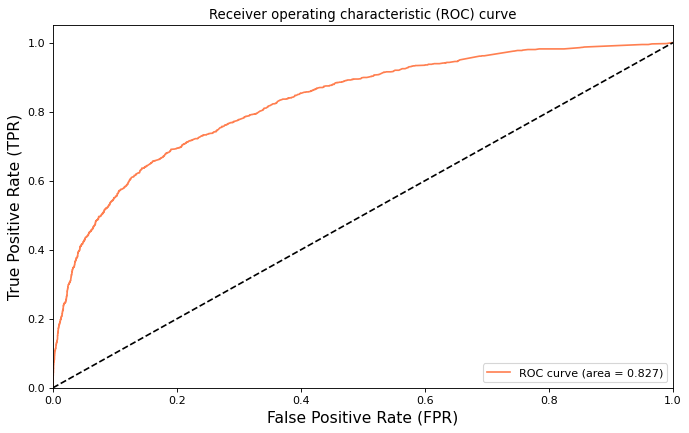

In [77]:
[fpr, tpr, thr] = roc_curve(y_train, pred_probs)

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [84]:
train_proba = pd.DataFrame({'Reorder_proba' : pred_probs})
train_proba

,Reorder_proba
0,0.723514
1,0.882467
2,0.065252
3,0.723514
4,0.488868
...,...
9995,0.243732
9996,0.121717
9997,0.311148
9998,0.377631


Best Threshold=0.156060, G-Mean=0.748


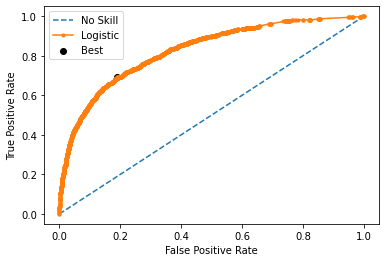

In [81]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from matplotlib import pyplot

fpr, tpr, thresholds = roc_curve(y_train, pred_probs)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [82]:
fpr, tpr, thresholds = roc_curve(y_train, pred_probs)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.156060


In [83]:
threshold = 0.16

test_reorder_p= (y_pred_prob >= threshold).astype('int')
test_reorder_p = pd.DataFrame({'Reorder_p' : test_reorder_p})
test_reorder_p

,Reorder_p
0,0
1,0
2,0
3,0
4,0
...,...
14708,0
14709,1
14710,0
14711,0
